
<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px">

*بخش مجموعه داده:*
---


## Step 1: Load the Dataset and Tokenize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import random
from datasets import load_dataset
from collections import Counter
import string

# Load the dataset
dataset = load_dataset("EdinburghNLP/xsum")

# Use only 30% for training and 10% for validation
train_size = int(0.3 * len(dataset['train']))
val_size = int(0.1 * len(dataset['validation']))

train_data = dataset['train'].select(random.sample(range(len(dataset['train'])), train_size))
val_data = dataset['validation'].select(random.sample(range(len(dataset['validation'])), val_size))

# Tokenizer function
def tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()  # Split by white-space
    return tokens


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

## Step 2: Vocabulary Building

In [ ]:
class Vocabulary:
    def __init__(self, cutoff=10):
        self.token_to_id = {}
        self.id_to_token = {}
        self.cutoff = cutoff
        self.special_tokens = ['<pad>', '<unk>', '<s>', '</s>']

    def build_vocab(self, tokenized_texts):
        # Count tokens
        counter = Counter(token for text in tokenized_texts for token in text)

        # Add special tokens
        for token in self.special_tokens:
            self.token_to_id[token] = len(self.token_to_id)

        # Add tokens based on cutoff
        for token, freq in counter.items():
            if freq >= self.cutoff:
                self.token_to_id[token] = len(self.token_to_id)

        # Reverse mapping
        self.id_to_token = {v: k for k, v in self.token_to_id.items()}

    def token_to_id_mapping(self, token):
        return self.token_to_id.get(token, self.token_to_id['<unk>'])

    def id_to_token_mapping(self, token_id):
        return self.id_to_token.get(token_id, '<unk>')

    def vocab_size(self):
        return len(self.token_to_id)

# Build Vocabulary using training set
train_texts = [tokenize(item['document']) for item in train_data]
vocab = Vocabulary(cutoff=10)
vocab.build_vocab(train_texts)


## Step 3: Example Output

In [ ]:
# Display vocabulary details
print("Vocabulary Size:", vocab.vocab_size())
print("Token ID for '<pad>':", vocab.token_to_id_mapping('<pad>'))
print("ID for 'quick':", vocab.token_to_id_mapping('quick'))
print("Token for ID 0:", vocab.id_to_token_mapping(0))


Vocabulary Size: 48001
Token ID for '<pad>': 0
ID for 'quick': 5547
Token for ID 0: <pad>


<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px">

*د*
---


## Step 1 & 2: Load GloVe Embeddings and Build the Embedding Matrix

In [ ]:
# Download GloVe embeddings in Colab
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove.6B/


In [ ]:
import numpy as np

class GloveEmbeddings:
    def __init__(self, glove_path, vocab, embedding_dim=100):
        self.glove_path = glove_path
        self.vocab = vocab
        self.embedding_dim = embedding_dim
        self.embedding_matrix = None

    def load_glove_vectors(self):
        glove_vectors = {}
        with open(self.glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                glove_vectors[word] = vector
        return glove_vectors

    def build_embedding_matrix(self):
        glove_vectors = self.load_glove_vectors()
        vocab_size = self.vocab.vocab_size()
        self.embedding_matrix = np.zeros((vocab_size, self.embedding_dim))  # Initialize with zeros

        for token, idx in self.vocab.token_to_id.items():
            if token in glove_vectors:
                self.embedding_matrix[idx] = glove_vectors[token]
            elif token in self.vocab.special_tokens:  # Special tokens remain zero
                continue
            else:
                self.embedding_matrix[idx] = np.random.normal(size=(self.embedding_dim,))  # Random for OOV tokens

        return self.embedding_matrix

# Path to the GloVe embeddings file
glove_path = "/content/drive/MyDrive/glove.6B/glove.6B.100d.txt"

# Create embedding object and build the matrix
glove_embeddings = GloveEmbeddings(glove_path, vocab, embedding_dim=100)
embedding_matrix = glove_embeddings.build_embedding_matrix()

# Print the embedding for three randomly chosen words
random_words = random.sample(list(vocab.token_to_id.keys()), 3)
for word in random_words:
    word_id = vocab.token_to_id_mapping(word)
    print(f"Embedding for '{word}' (ID {word_id}): {embedding_matrix[word_id]}")


Embedding for 'mf' (ID 39066): [-0.41892999 -0.096534    0.47202    -1.02119994 -0.014743   -0.91459
  0.21323    -0.75681001 -1.14549994  0.71893001  0.68309999  0.040985
 -0.10417     0.10638     0.82459003 -0.37849    -0.19964001 -0.69199997
 -0.12847     0.27182999 -0.10604    -0.015104    0.074401    0.60229999
  0.071022    0.70740998 -0.059076    0.50520003 -0.096826    1.40750003
 -0.20749     0.24137001 -0.53254998  1.06470001 -0.84416997 -0.33949
  0.10153     0.068468    0.73210001 -0.28716999  0.10753     0.016682
 -1.00549996 -0.46233001 -0.55745     0.23919    -0.065444   -0.11947
 -0.97662002  0.18553001 -0.62748998  0.045587   -0.81155998 -0.86892003
  0.096134   -0.23885     0.30666     0.14357001 -0.71078998  0.13593
  0.12328     0.011062   -0.72264999  0.036916   -0.37283999  0.11319
  0.054581   -0.24167     0.74896997 -0.33096001  0.033606   -0.18897
 -0.13       -0.24790999 -0.45680001 -1.21379995  0.56896001 -0.38801
 -1.04299998 -1.17369998  0.51431    -0.62588

<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px">


*بخش اول:*
---

## Step 1: Define Dataset and Collate Function

In [ ]:
  import torch
  from torch.utils.data import Dataset, DataLoader

  class SummarizationDataset(Dataset):
      def __init__(self, data, vocab):
          self.data = data
          self.vocab = vocab

      def __len__(self):
          return len(self.data)

      def __getitem__(self, idx):
          document = self.data[idx]['document']
          summary = self.data[idx]['summary']
          doc_tokens = [self.vocab.token_to_id_mapping(token) for token in tokenize(document)]
          summary_tokens = [self.vocab.token_to_id_mapping(token) for token in tokenize(summary)]
          return torch.tensor(doc_tokens), torch.tensor(summary_tokens)


def collate_fn(batch):
    # Extract documents and summaries
    documents, summaries = zip(*batch)

    # Ensure documents and summaries are PyTorch tensors
    documents = [doc.clone().detach() if isinstance(doc, torch.Tensor) else torch.tensor(doc) for doc in documents]
    summaries = [sum.clone().detach() if isinstance(sum, torch.Tensor) else torch.tensor(sum) for sum in summaries]

    # Calculate average lengths for the batch
    avg_doc_length = int(sum([len(doc) for doc in documents]) / len(documents))
    avg_sum_length = int(sum([len(sum) for sum in summaries]) / len(summaries))

    # Trim sequences to the average length or pad to the average length
    def trim_or_pad(sequences, target_length, padding_value):
        trimmed_or_padded = []
        for seq in sequences:
            if len(seq) > target_length:
                trimmed_or_padded.append(seq[:target_length])  # Trim to target length
            else:
                # Pad to target length
                padding = torch.full((target_length - len(seq),), padding_value, dtype=torch.long)
                trimmed_or_padded.append(torch.cat((seq, padding)))
        return torch.stack(trimmed_or_padded)

    documents_padded = trim_or_pad(documents, avg_doc_length, vocab.token_to_id_mapping('<pad>'))
    summaries_padded = trim_or_pad(summaries, avg_sum_length, vocab.token_to_id_mapping('<pad>'))

    # Create masks
    documents_mask = (documents_padded != vocab.token_to_id_mapping('<pad>')).float()
    summaries_mask = (summaries_padded != vocab.token_to_id_mapping('<pad>')).float()

    return documents_padded, summaries_padded, documents_mask, summaries_mask


## Step 2: Create Dataset and DataLoader

In [ ]:
# Create Dataset
train_dataset = SummarizationDataset(train_data, vocab)
val_dataset = SummarizationDataset(val_data, vocab)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


<div dir="rtl" style="font-family: Vazir; width: 85%; font-size: 16px">


*بخش دوم:*
---

## Step 1: Define the Model

In [ ]:
import torch.nn as nn
import torch.optim as optim

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, embedding_matrix):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Freeze embedding weights
        # self.gru = nn.GRU(embedding_size, hidden_size, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(embedding_size, hidden_size, batch_first=True, bidirectional=True, dropout=0.4)
        self.batch_norm = nn.BatchNorm1d(embedding_size)

        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                torch.nn.init.zeros_(param)


    def forward(self, x, mask):
        x = x.to(self.embedding.weight.device).long()  # Ensure x is on the same device as the embedding layer
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_size)
        embedded = self.batch_norm(embedded.transpose(1, 2)).transpose(1, 2)
        outputs, hidden = self.gru(embedded)  # outputs: (batch_size, seq_len, 2*hidden_size)
        return outputs, hidden  # hidden: (2, batch_size, hidden_size)


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 3, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))  # Remains a Parameter

    def forward(self, hidden, encoder_outputs, mask):
        device = encoder_outputs.device  # Get the device of encoder outputs
        hidden = hidden.to(device)
        mask = mask.to(device)
        self.attn = self.attn.to(device)
        # self.v = self.v.to(device)

        # Use the last layer of the decoder's hidden state
        hidden = hidden[-1].unsqueeze(1)  # (batch_size, 1, hidden_size)

        # Repeat hidden across the sequence length for concatenation
        hidden_repeated = hidden.repeat(1, encoder_outputs.size(1), 1)  # (batch_size, seq_len, hidden_size)

        # Concatenate hidden and encoder outputs
        energy = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2))).to(self.v.device)  # (batch_size, seq_len, hidden_size)

        # Compute attention scores
        energy = torch.sum(energy * self.v, dim=2).to(device)  # (batch_size, seq_len)
        energy = energy.masked_fill(mask == 0, -1e10)  # Apply mask

        # Compute attention weights
        attention_weights = torch.nn.functional.softmax(energy, dim=1)  # (batch_size, seq_len)

        # Compute context vector
        context = torch.sum(encoder_outputs * attention_weights.unsqueeze(2), dim=1)  # (batch_size, 2 * hidden_size)

        return context, attention_weights


class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, embedding_matrix):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Freeze embedding weights
        self.gru = nn.GRU(embedding_size + hidden_size * 2, hidden_size, batch_first=True, dropout=0.4)
        self.batch_norm = nn.BatchNorm1d(embedding_size)
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                torch.nn.init.zeros_(param)

        self.fc = nn.Linear(hidden_size * 3, vocab_size)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, encoder_outputs, mask):
        x = x.to(self.embedding.weight.device).long()  # Ensure x is on the same device as the embedding layer
        embedded = self.embedding(x)  # (batch_size, embedding_size)

        # Fix: Add sequence length dimension
        embedded = embedded.unsqueeze(1)  # (batch_size, 1, embedding_size)
        embedded = self.batch_norm(embedded.transpose(1, 2)).transpose(1, 2)

        context, _ = self.attention(hidden, encoder_outputs, mask)

        # Concatenate embedded and context tensors
        rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)  # (batch_size, 1, embedding_size + 2 * hidden_size)

        outputs, hidden = self.gru(rnn_input, hidden)
        logits = self.fc(torch.cat((outputs.squeeze(1), context), dim=1))  # (batch_size, vocab_size)
        return logits, hidden


## Step 3: Hyperparameters

In [ ]:
# Hyperparameters
embedding_size = 100
hidden_size = 100
batch_size = 32
num_epochs = 10
learning_rate = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=4)

# Model Initialization
vocab_size = vocab.vocab_size()
encoder = Encoder(vocab_size, embedding_size, hidden_size, embedding_matrix)
attention = Attention(hidden_size)
decoder = Decoder(vocab_size, embedding_size, hidden_size, embedding_matrix)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


# PArt 5

## Step 1: Define Inference Function

In [ ]:
def top_k_sampling(logits, k=5):
    """
    Perform top-k sampling from the logits.

    Parameters:
    - logits: Tensor of shape (vocab_size,)
    - k: int, number of top tokens to consider for sampling

    Returns:
    - Selected token ID
    """
    # Get the top-k logits and their indices
    top_k_logits, top_k_indices = torch.topk(logits, k)

    # Apply softmax to the top-k logits for probabilities
    top_k_probs = torch.softmax(top_k_logits, dim=-1)

    # Sample from the top-k probabilities
    sampled_index = top_k_indices[torch.multinomial(top_k_probs, num_samples=1)].item()
    return sampled_index


def generate_summary(encoder, decoder, document, document_mask, vocab, max_len=50, k=5):

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        # Pass through encoder
        encoder_outputs, hidden = encoder(document, document_mask)
        decoder_input = torch.full(
            (document.size(0),), vocab.token_to_id_mapping('<s>'), device=document.device, dtype=torch.long
        )
        decoder_hidden = hidden[:1]  # Use the forward GRU output from bidirectional GRU

        generated_tokens = []

        for _ in range(max_len):
            decoder_logits, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs, document_mask)
            logits = decoder_logits.squeeze(0)  # Assuming batch size of 1

            # Apply top-k sampling
            decoder_input = torch.tensor([top_k_sampling(logits, k)], device=document.device, dtype=torch.long)

            generated_tokens.append(decoder_input.item())

            if decoder_input.item() == vocab.token_to_id_mapping('</s>'):  # Stop if end token is generated
                break

        # Convert IDs back to tokens
        generated_summary = [
            vocab.id_to_token_mapping(token) for token in generated_tokens if token not in [vocab.token_to_id_mapping('<pad>')]
        ]
        return " ".join(generated_summary)


## Step 2: Generate Summaries for Fixed Samples

In [ ]:
def validate_and_print_summaries(encoder, decoder, val_loader, vocab, epoch, device, num_samples=3):
    encoder.to(device)
    decoder.to(device)

    fixed_samples = []
    for i, (documents, summaries, document_masks, summary_masks) in enumerate(val_loader):
        documents = documents.to(device)
        document_masks = document_masks.to(device)

        # Select the first `num_samples` documents from the batch
        for j in range(min(num_samples, documents.size(0))):
            fixed_samples.append((documents[j].unsqueeze(0), document_masks[j].unsqueeze(0)))
        break  # Use only the first batch

    print(f"\nSummaries at Epoch {epoch + 1}:\n")
    for i, (document, document_mask) in enumerate(fixed_samples):
        generated_summary = generate_summary(encoder, decoder, document, document_mask, vocab)
        print(f"Sample {i + 1}:")
        print(f"Generated Summary: {generated_summary}")
        print("---")


## Step 3: Install ROUGE Library

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics commonly used in **Natural Language Processing (NLP)** to evaluate the quality of text summaries or generated content by comparing them to reference texts. It measures the overlap between the generated text and the reference text based on n-grams, word sequences, and longest common subsequences.

### Key ROUGE Metrics:
1. **ROUGE-N**:
   - Measures the overlap of **n-grams** (e.g., unigrams, bigrams).
   - Example: ROUGE-1 (unigrams), ROUGE-2 (bigrams).
   - **Formula**:
     ROUGE-N = Overlapping n-grams in candidate and reference / Total n-grams in reference
     

2. **ROUGE-L**:
   - Measures the **longest common subsequence (LCS)** between the candidate and reference text.
   - Captures fluency and sequence similarity.

3. **ROUGE-W**:
   - Weighted variant of ROUGE-L that considers the importance of long contiguous subsequences.

4. **ROUGE-S**:
   - Measures skip-bigram overlap, allowing non-consecutive matching of word pairs.


In [ ]:
!pip install rouge


## Step 4: Evaluate Model and Plot Results

In [ ]:
# Function to plot metrics
def plot_metrics(train_losses, val_losses, train_rouge, val_rouge, epochs):
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Plot ROUGE-L
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_rouge, label="Training ROUGE-L")
    plt.plot(range(1, epochs + 1), val_rouge, label="Validation ROUGE-L")
    plt.title("ROUGE-L vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("ROUGE-L Score")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=52e5b0838c297c4641afe4f20037c114191ac2d129293e27290df9ab62fe55dc
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from rouge_score import rouge_scorer

def evaluate_model(encoder, decoder, dataloader, vocab, device):
    encoder.eval()
    decoder.eval()

    total_loss = 0
    total_rouge_1, total_rouge_2, total_rouge_l = 0, 0, 0
    num_samples = 0
    criterion = torch.nn.CrossEntropyLoss()

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    with torch.no_grad():
        for documents, summaries, document_masks, summary_masks in tqdm(dataloader, desc="Evaluating"):
            documents = documents.to(device)
            summaries = summaries.to(device)
            document_masks = document_masks.to(device)

            # Forward pass through encoder
            encoder_outputs, hidden = encoder(documents, document_masks)

            # Initialize decoder inputs
            decoder_input = torch.full((documents.size(0),), vocab.token_to_id_mapping('<s>'), device=device, dtype=torch.long)
            decoder_hidden = hidden[:1]

            batch_loss = 0
            generated_summaries = []

            # Generate summaries and calculate loss
            for t in range(summaries.size(1)):
                decoder_logits, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs, document_masks)
                loss = criterion(decoder_logits, summaries[:, t].long())
                batch_loss += loss

                # Greedy decoding
                predicted_tokens = torch.argmax(decoder_logits, dim=1)
                decoder_input = predicted_tokens  # Next input for decoder

                # Collect generated tokens for each sample
                generated_summaries.append(predicted_tokens.cpu().numpy())

            # Convert generated summaries and references to text
            generated_summaries = [" ".join(vocab.id_to_token_mapping(token) for token in sample) for sample in zip(*generated_summaries)]
            reference_summaries = [" ".join(vocab.id_to_token_mapping(token.item()) for token in summary if token.item() != vocab.token_to_id_mapping('</s>')) for summary in summaries]

            # Calculate ROUGE scores
            for generated, reference in zip(generated_summaries, reference_summaries):
                scores = scorer.score(reference, generated)
                total_rouge_1 += scores['rouge1'].fmeasure
                total_rouge_2 += scores['rouge2'].fmeasure
                total_rouge_l += scores['rougeL'].fmeasure

            total_loss += batch_loss.item()
            num_samples += len(documents)

    # Compute average loss and ROUGE scores
    avg_loss = total_loss / num_samples
    avg_rouge_1 = total_rouge_1 / num_samples
    avg_rouge_2 = total_rouge_2 / num_samples
    avg_rouge_l = total_rouge_l / num_samples

    return avg_loss, avg_rouge_1, avg_rouge_2, avg_rouge_l


## Step 5: Integrate into Training Loop

In [ ]:
import os
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

def save_checkpoint(epoch, encoder, decoder, optimizer, train_loss, val_loss, filepath):
    """Save model checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at {filepath}")

def train_model(encoder, decoder, dataloader, val_loader, criterion, optimizer, num_epochs, vocab, device, checkpoint_dir='./checkpoints'):
    os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure the checkpoint directory exists
    encoder.to(device)
    decoder.to(device)
    scaler = GradScaler(init_scale=5.0)
    num_samples = 0

    train_losses, val_losses = [], []
    train_rouge, val_rouge = [], []
    losses = []
    best_val_loss = float('inf')  # To track the best validation loss

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        encoder.train()
        decoder.train()
        total_loss = 0
        teacher_forcing_ratio = max(0.5, 1 - epoch / num_epochs)

        optimizer.zero_grad()

        for documents, summaries, document_masks, summary_masks in tqdm(dataloader):
            documents = documents.to(device)
            summaries = summaries.to(device)
            document_masks = document_masks.to(device)

            with autocast(dtype=torch.float16):
                # Encoder forward pass
                encoder_outputs, hidden = encoder(documents, document_masks)

                # Initialize decoder inputs
                decoder_input = torch.full((documents.size(0),), vocab.token_to_id_mapping('<s>'), device=device, dtype=torch.long)
                decoder_hidden = hidden[:1]  # Use the forward GRU output from bidirectional GRU

                batch_loss = 0

                # Teacher forcing
                for t in range(summaries.size(1)):
                    decoder_logits, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs, document_masks)
                    if torch.isnan(decoder_logits).any():
                        print(decoder_input)
                    loss = criterion(decoder_logits, summaries[:, t].long())
                    batch_loss += loss
                    # decoder_input = summaries[:, t]  # Teacher forcing

            scaler.scale(batch_loss).backward()  # Backpropagate scaled loss (if mixed precision)
            scaler.unscale_(optimizer)  # Unscale gradients for clipping
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=5.0)  # Gradient clipping
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=5.0)  # Gradient clipping
            scaler.step(optimizer)  # Update parameters
            scaler.update()  # Update scaler for next iteration

            total_loss += batch_loss.item()
            num_samples += len(documents)

        avg_train_loss = total_loss / num_samples
        # avg_train_loss = sum(losses) / len(losses)
        _, avg_train_rouge_1, avg_train_rouge_2, avg_train_rouge_l = evaluate_model(encoder, decoder, dataloader, vocab, device)
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"  Training Loss: {avg_train_loss:.4f} , Training ROUGE-L: {avg_train_rouge_l:.4f}")
        avg_val_loss, avg_val_rouge_1, avg_val_rouge_2, avg_val_rouge_l = evaluate_model(encoder, decoder, val_loader, vocab, device)
        print(f"  Validation Loss: {avg_val_loss:.4f}, Validation ROUGE-L: {avg_val_rouge_l:.4f}")

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_rouge.append(avg_train_rouge_l)
        val_rouge.append(avg_val_rouge_l)

        # Save checkpoint if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(
                epoch + 1,
                encoder,
                decoder,
                optimizer,
                avg_train_loss,
                avg_val_loss,
                os.path.join(checkpoint_dir, f"best_checkpoint_epoch_{epoch + 1}.pt")
            )

        # Generate summaries for validation samples
        validate_and_print_summaries(encoder, decoder, val_loader, vocab, epoch, device)

    plot_metrics(train_losses, val_losses, train_rouge, val_rouge, num_epochs)


In [ ]:
# Hyperparameters
embedding_size = 100
hidden_size = 100
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=4)

# Model Initialization
vocab_size = vocab.vocab_size()
encoder = Encoder(vocab_size, embedding_size, hidden_size, embedding_matrix)
attention = Attention(hidden_size)
decoder = Decoder(vocab_size, embedding_size, hidden_size, embedding_matrix)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


## Step 6: Training

<ipython-input-18-0e85c999a2e0>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(init_scale=5.0)
  0%|          | 0/1913 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-0e85c999a2e0>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Evaluating: 100%|██████████| 1913/1913 [03:17<00:00,  9.70it/s]


Epoch 1/10:
  Training Loss: 4.3371 , Training ROUGE-L: 0.0975


Evaluating: 100%|██████████| 36/36 [00:03<00:00, 10.09it/s]


  Validation Loss: 4.8922, Validation ROUGE-L: 0.0963
Checkpoint saved at ./checkpoints/best_checkpoint_epoch_1.pt

Summaries at Epoch 1:

Sample 1:
Generated Summary: a scottish of scotland the of the the scottish the in the the to scottish a wildlife it scottish the of to scotlands the to scottish a to scotlands the of of it scotlands the scottish of the the the the to the scottish in scotland the the it the
---
Sample 2:
Generated Summary: venezuelas turkish a recep the russian the has russia the president it nato the ukraine a ukraine the us talks turkish the has ukraine the president of ukraine a president it president the turkish of tayyip the president the russia in ukraine a nato it president a ukraine it president
---
Sample 3:
Generated Summary: an minister the has it the it migrants the has eu the eu has it the eu the to refugees the uk the has refugees a migrants the eu has has it uk the eu a refugees it prime a eu the minister the minister the the a refugees the
---


Evaluating: 100%|██████████| 1913/1913 [03:05<00:00, 10.34it/s]


Epoch 2/10:
  Training Loss: 2.0083 , Training ROUGE-L: 0.1084


Evaluating: 100%|██████████| 36/36 [00:03<00:00, 10.49it/s]


  Validation Loss: 4.5032, Validation ROUGE-L: 0.1058
Checkpoint saved at ./checkpoints/best_checkpoint_epoch_2.pt

Summaries at Epoch 2:

Sample 1:
Generated Summary: the of a have of the a the the to the the to to a the the of to to to the of to the the the to of the a the and to a the a a the of the of the the the of a to the and
---
Sample 2:
Generated Summary: russian russian of the have the has the to in in in of the a a of a and a of of of the the and the to to a to the and of to the a and a the the to to the and the the and a the
---
Sample 3:
Generated Summary: the prime says the said the to to to the in migrants of of in in in the in the to to the of the the the the to to to the of the to of the to to the the the the the the the migrants the migrants to
---


Evaluating: 100%|██████████| 1913/1913 [03:08<00:00, 10.13it/s]


Epoch 3/10:
  Training Loss: 1.2967 , Training ROUGE-L: 0.1163


Evaluating: 100%|██████████| 36/36 [00:05<00:00,  6.45it/s]


  Validation Loss: 4.4690, Validation ROUGE-L: 0.1136
Checkpoint saved at ./checkpoints/best_checkpoint_epoch_3.pt

Summaries at Epoch 3:

Sample 1:
Generated Summary: the have have have are the to to of of in the the a the in in in of of a of the to in of of of a in of in the to the the a a of of the the a a in to the the a of
---
Sample 2:
Generated Summary: russia president has have have has the in in to in in to and the the the the the the to in the the to to the and of in the and the in of the the and in to in the the the in of the the and in
---
Sample 3:
Generated Summary: the cameron minister minister the has to has has to the migrant to migrant to of the the to to the the to the to to to refugees to to the of refugees the the the refugees migrant to migrant the to the migrant to migrant said to to migrant
---


Evaluating: 100%|██████████| 1913/1913 [03:05<00:00, 10.30it/s]


Epoch 4/10:
  Training Loss: 0.9529 , Training ROUGE-L: 0.1189


Evaluating: 100%|██████████| 36/36 [00:04<00:00,  7.34it/s]


  Validation Loss: 4.4572, Validation ROUGE-L: 0.1125
Checkpoint saved at ./checkpoints/best_checkpoint_epoch_4.pt

Summaries at Epoch 4:

Sample 1:
Generated Summary: a are have have a scotland to of to of of the to to the the the scotland the the the scotland scotland scotland of the of a the the of in the the the scotland the scotland the the the the scotland scotland of the the of the scotland
---
Sample 2:
Generated Summary: the government has have have to the the the in in of in of of and the the in of of the russia russia in and the and and the of of the russia russia the and of the the the the the the of the the in and a
---
Sample 3:
Generated Summary: the secretary minister minister to said has the migrant migrant to the to the to migrant of migrant migrant to migrant migrant migrant the of of to migrant migrant the migrant to migrant said the migrant migrant migrant said migrant migrant to migrant migrant migrant migrant said migrant migrant migrant
---


Evaluating: 100%|██████████| 1913/1913 [03:10<00:00, 10.03it/s]


Epoch 5/10:
  Training Loss: 0.7504 , Training ROUGE-L: 0.1206


Evaluating: 100%|██████████| 36/36 [00:04<00:00,  8.28it/s]


  Validation Loss: 4.4541, Validation ROUGE-L: 0.1152
Checkpoint saved at ./checkpoints/best_checkpoint_epoch_5.pt

Summaries at Epoch 5:

Sample 1:
Generated Summary: a scottish to scotlands scotlands to to a in the of in the to a the a to the the a to the the a the of to the of of of the a a in to the to to to the a the to of the the of of
---
Sample 2:
Generated Summary: the has has has the have have the to the the in in and to of to the to of in of of of the the the in the and to of and the in of the the the to of in and in and of the and of to
---
Sample 3:
Generated Summary: the secretary minister has has has has the the to to migrants the to to to the migrants the migrants the the migrants to a the the migrants migrants the the the the the the the migrants migrants to a the migrants a a migrants to a migrants to the
---


Evaluating: 100%|██████████| 1913/1913 [03:12<00:00,  9.92it/s]


Epoch 6/10:
  Training Loss: 0.6178 , Training ROUGE-L: 0.1229


Evaluating: 100%|██████████| 36/36 [00:05<00:00,  6.64it/s]


  Validation Loss: 4.4538, Validation ROUGE-L: 0.1150
Checkpoint saved at ./checkpoints/best_checkpoint_epoch_6.pt

Summaries at Epoch 6:

Sample 1:
Generated Summary: scotlands scottish of scotland of the the of of to of in the to of the of scotland of of scotland to in in of scotland the to to the of the to a the the in the in a the the a a of of a in in the
---
Sample 2:
Generated Summary: the is parliament has have has the ukraine in ukraine to ukraine to the to ukraine of of ukraine of the ukraine ukraine in and ukraine and ukraine the the of to the to and of of ukraine of to to the the the the the of of to of
---
Sample 3:
Generated Summary: the cameron minister cameron has the has to a to to to a the the the the eu the the the a the a migrant migrant the the said to to said the the eu eu the the a to said the said the to to said eu eu said
---


Evaluating: 100%|██████████| 1913/1913 [03:06<00:00, 10.24it/s]


Epoch 7/10:
  Training Loss: 0.5246 , Training ROUGE-L: 0.1259


Evaluating: 100%|██████████| 36/36 [00:05<00:00,  7.05it/s]


  Validation Loss: 4.4537, Validation ROUGE-L: 0.1179
Checkpoint saved at ./checkpoints/best_checkpoint_epoch_7.pt

Summaries at Epoch 7:

Sample 1:
Generated Summary: a of the of the the the of of of in to the of the of a to a in of the the in the the to in the the in the the the the of in in the the conservationists the the conservationists conservationists conservationists to to the conservationists
---
Sample 2:
Generated Summary: russia forces has has is has a to the to of to a the to in in in and of in of to the to the of the of the of the in of of the to to the of of and in the the the of of of the
---
Sample 3:
Generated Summary: the uk minister has has to to the to of the migrant the to in to to the migrant to the to the to to to the the to the immigration the the to said to migrants migrant migrants migrants migrants to the to the to to said to to
---


Evaluating: 100%|██████████| 1913/1913 [03:11<00:00,  9.99it/s]


Epoch 8/10:
  Training Loss: 0.4558 , Training ROUGE-L: 0.1298


Evaluating: 100%|██████████| 36/36 [00:05<00:00,  6.83it/s]

  Validation Loss: 4.4572, Validation ROUGE-L: 0.1196



Summaries at Epoch 8:

Sample 1:
Generated Summary: scottish scottish hunting have scotlands the to the a to a of the a a a in of a in to the the in in a the the the of in the a the the a the to of to the in to to of a to the a a
---
Sample 2:
Generated Summary: ukraines un state has has has in to in the a to the the eastern the a the of of of of of of a a eastern in eastern of the eastern ukraine of of a of of the the in ukraine the of eastern in in ukraine of the
---
Sample 3:
Generated Summary: a secretary minister has has he to to to to to to the the to to to a to refugees to the the the minister the the said a to to refugees refugees the said the to refugees said the a to the said the to a the to refugees
---


Evaluating: 100%|██████████| 1913/1913 [03:12<00:00,  9.91it/s]


Epoch 9/10:
  Training Loss: 0.4023 , Training ROUGE-L: 0.1303


Evaluating: 100%|██████████| 36/36 [00:03<00:00, 10.14it/s]

  Validation Loss: 4.4611, Validation ROUGE-L: 0.1171



Summaries at Epoch 9:

Sample 1:
Generated Summary: the government the the to to on the of marine the to a the marine the the marine the the the the marine the the to of of the marine the a marine to a the marine of of the marine the the the marine to a a the of
---
Sample 2:
Generated Summary: ukrainian forces have has has a the to in russia the the russia in rebels in in russia the rebels the russia russia the in the of of the the of the of and of the and the on the the the the of the in on in in the
---
Sample 3:
Generated Summary: a eu minister minister said said a to a to to the a of the the of to the of the refugees the migrant migrant eu refugees to refugees migrants migrant migrants to refugees refugees migrant the migrants the migrants migrants the the migrant to a refugees to the migrants
---


Evaluating: 100%|██████████| 1913/1913 [03:15<00:00,  9.81it/s]


Epoch 10/10:
  Training Loss: 0.3599 , Training ROUGE-L: 0.1323


Evaluating: 100%|██████████| 36/36 [00:03<00:00, 10.52it/s]

  Validation Loss: 4.4624, Validation ROUGE-L: 0.1199



Summaries at Epoch 10:

Sample 1:
Generated Summary: the government of have to of the the to the to of the to to in to of the a the a the the of the of the the the in the the to of the of the the a to the in of the a a to a to
---
Sample 2:
Generated Summary: the un has has has have to to in of of of in the to eastern the the the the the of the the in the in of eastern the to eastern the of of the the military the in the military military eastern of eastern the of military of
---
Sample 3:
Generated Summary: prime minister government to migrants to refugees of the to the to to of of the migrants migrants to refugees migrants migrants the migrant refugees the migrants to the the to refugees migrants migrant refugees migrants refugees to the to to the migrants the the the migrants migrants refugees the
---


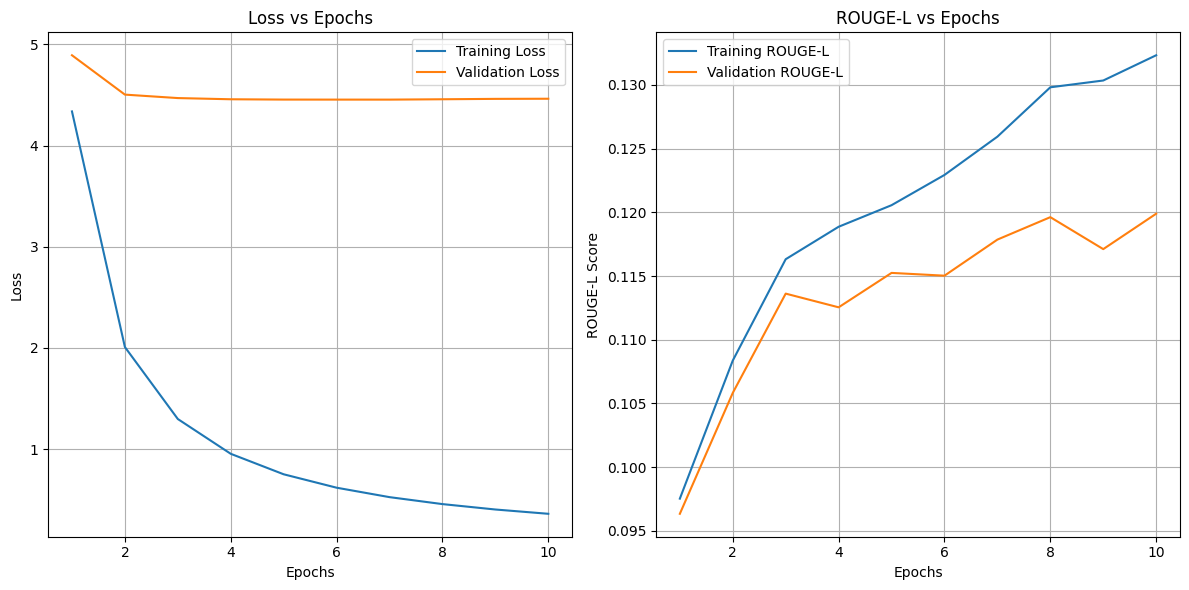

In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab.token_to_id_mapping('<pad>'))
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate, weight_decay=1e-5)

# Training
train_model(encoder, decoder, train_loader, val_loader, criterion, optimizer, num_epochs, vocab, device)


## Analysis Summary:

    Early Epochs (1–3): Highly repetitive, nonsensical text with no meaningful structure. The model is learning basic patterns but lacks context.
    Middle Epochs (4–6): Slight improvement; domain-specific words appear (e.g., "scotland," "ukraine"), but repetitions persist.
    Later Epochs (7–10): Better topic relevance and reduced repetition, but fluency and diversity are still lacking.

### Conclusion:

The summaries improve gradually, showing better alignment with the context. However, issues like redundancy and lack of fluency remain, suggesting the need for further optimization (e.g., lower dropout, reduce reguarization term etc.).